## Load Dataset Split it into Train:Val:Test = 100:25:25

In [76]:
##--- load data from scikit ---##
import numpy as np
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
from sklearn.datasets import load_iris

## Set Seed
seed = 20

## Load dataset
iris_dataset = load_iris()
X = np.array(iris_dataset['data'])
y = np.array(iris_dataset['target'])

## one-hot encoding
Y = list()
for i in y:
    letter = [0, 0, 0]
    letter[i] = 1
    Y.append(letter)
Y = np.array(Y) 

## Random shuffle data and train-test split
test_Idx = np.random.RandomState(seed=seed).permutation(Y.shape[0])
X_test = X[test_Idx[:25]]
Y_test = Y[test_Idx[:25]]
X = X[test_Idx[25:]]
Y = Y[test_Idx[25:]]

# Random shuffle data
Idx = np.random.RandomState(seed=seed).permutation(Y.shape[0])
##--- Prepare training and validation data ---#
# Prepare indexing for each fold
X_val = X[Idx[:25]]
Y_val = Y[Idx[:25]]
Idxtrn = np.setdiff1d(Idx, Idx[:25])
X_train = X[Idxtrn]
Y_train = Y[Idxtrn]

pandas version: 1.4.3
scikit-learn version: 1.1.1


## Model Training

In [77]:
from sklearn.preprocessing import PolynomialFeatures
error_rate_train_array = []
error_rate_val_array = []
wps = []
##--- Loop for Polynomial orders 1 to 10 ---##
for order in range(1,11):

    
    
    ##--- Polynomial Classification ---##
    poly = PolynomialFeatures(order)
    P = poly.fit_transform(X_train)
    Pval = poly.fit_transform(X_val)
    if P.shape[0] > P.shape[1]: # over-/under-determined cases
        reg_L = 0.00*np.identity(P.shape[1])
        inv_PTP = np.linalg.inv(P.transpose().dot(P)+reg_L)
        pinv_L = inv_PTP.dot(P.transpose())
        wp = pinv_L.dot(Y_train)
    else:
        reg_R = 0.00*np.identity(P.shape[0])
        inv_PPT = np.linalg.inv(P.dot(P.transpose())+reg_R)
        pinv_R = P.transpose().dot(inv_PPT)
        wp = pinv_R.dot(Y_train)
        
    wps.append(wp)
    ##--- trained output ---##
    y_train_p = P.dot(wp); 
    y_train_p_index = y_train_p.argmax(axis=-1)
    y_train_pred = np.zeros_like(y_train_p)
    y_train_pred[np.arange(y_train_p.shape[0]), y_train_p_index] = 1

    # training classification error count and rate computation
    difference = np.abs(Y_train - y_train_pred)
    error_train = np.where(difference.any(axis=1))[0]
    error_rate_train = len(error_train)/len(difference)

    ##--- validation output ---##
    y_val_p = Pval.dot(wp)
    y_val_p_index = y_val_p.argmax(axis=-1)
    y_val_pred = np.zeros_like(y_val_p)
    y_val_pred[np.arange(y_val_p.shape[0]), y_val_p_index] = 1

    # validation classification error count and rate computation
    difference = np.abs(Y_val - y_val_pred)
    error_val = np.where(difference.any(axis=1))[0]
    error_rate_val = len(error_val)/len(difference)

    error_rate_train_array += [error_rate_train] 
    error_rate_val_array += [error_rate_val] 

## Plot the Train-Val Error curve and select the best order

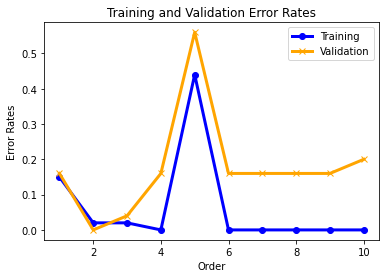

Best Order is 2


In [78]:
##--- plotting ---##
import matplotlib.pyplot as plt
order=[x for x in range(1,11)]
plt.plot(order, error_rate_train_array, color='blue', marker='o', linewidth=3, 
label='Training')
plt.plot(order, error_rate_val_array, color='orange', marker='x', linewidth=3, 
label='Validation')
plt.xlabel('Order')
plt.ylabel('Error Rates')
plt.title('Training and Validation Error Rates')
plt.legend()
plt.show()

# Select the best order according to the validation set
best_order = np.argmin(error_rate_val_array) 
print("Best Order is {}".format(best_order + 1))

## Test with the Best Order

In [79]:
# Evaluate on the test set
poly = PolynomialFeatures(best_order+1)
P_test = poly.fit_transform(X_test)

wp = wps[best_order]
y_test_p = P_test.dot(wp)
y_test_p_index = y_test_p.argmax(axis=-1)
y_test_pred = np.zeros_like(y_test_p)
y_test_pred[np.arange(y_test_p.shape[0]), y_test_p_index] = 1
# validation classification error count and rate computation
difference = np.abs(Y_test - y_test_pred)
error_test = np.where(difference.any(axis=1))[0]
error_rate_test = len(error_test)/len(difference)
print("The Testing Error Rate is {} %".format(error_rate_test *  100))

The Testing Error Rate is 4.0 %


## Tutorial 10 Question 6

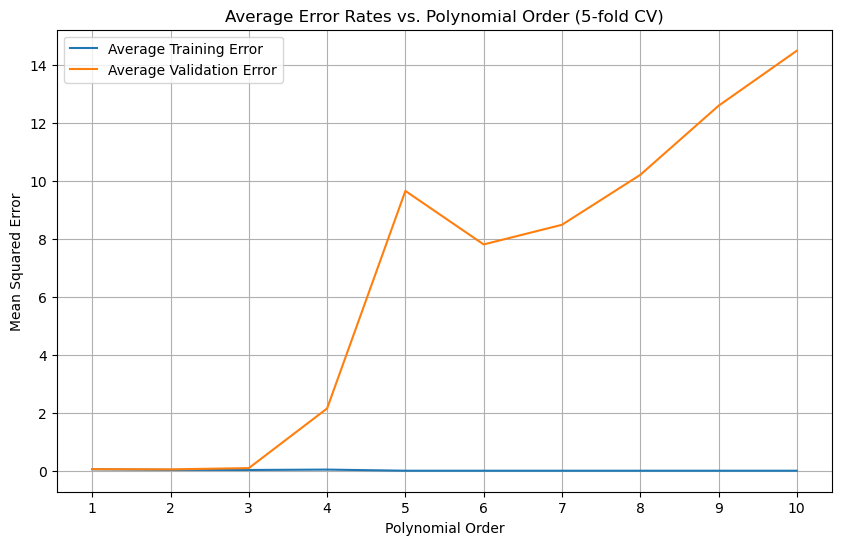

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # Validation set is 20% of train_val set

# Define polynomial orders to test
poly_orders = np.arange(1, 11)

# Initialize lists to store training and validation error rates
train_errors = []
val_errors = []

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for poly_order in poly_orders:
    train_fold_errors = []
    val_fold_errors = []
    for train_index, val_index in kf.split(X_train_val):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=poly_order)
        X_train_poly = poly_features.fit_transform(X_train_fold)
        X_val_poly = poly_features.transform(X_val_fold)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(X_train_poly, y_train_fold)

        # Calculate training and validation errors
        train_pred = model.predict(X_train_poly)
        val_pred = model.predict(X_val_poly)
        train_err = mean_squared_error(y_train_fold, train_pred)
        val_err = mean_squared_error(y_val_fold, val_pred)

        train_fold_errors.append(train_err)
        val_fold_errors.append(val_err)

    # Calculate average errors for this polynomial order
    train_errors.append(np.mean(train_fold_errors))  # Use np.mean() instead of directly appending 0
    val_errors.append(np.mean(val_fold_errors))

# Plot average error rates over polynomial orders
plt.figure(figsize=(10, 6))
plt.plot(poly_orders, train_errors, label='Average Training Error')
plt.plot(poly_orders, val_errors, label='Average Validation Error')
plt.xlabel('Polynomial Order')
plt.ylabel('Mean Squared Error')
plt.title('Average Error Rates vs. Polynomial Order (5-fold CV)')
plt.legend()
plt.grid(True)
plt.xticks(poly_orders)
plt.show()
